
   $$
   \frac{\partial \omega}{\partial t}
     + u\,\frac{\partial \omega}{\partial x}
     + v\,\frac{\partial \omega}{\partial y}
   = \nu\!\Bigl(\frac{\partial^2 \omega}{\partial x^2}
               +\frac{\partial^2 \omega}{\partial y^2}\Bigr),
   $$  


   $$
   \Delta\psi = -\,\omega, 
   \quad u = -\frac{\partial \psi}{\partial y}, 
   \quad v = \frac{\partial \psi}{\partial x}.
   $$  

  $$
  \omega(x,y,0) = -2 \cos x\,\cos y.
  $$
  $$
  \omega(0,y,t)=\omega(2\pi,y,t), 
  \quad 
  \omega(x,0,t)=\omega(x,2\pi,t).
  $$
  $$(x,y)\in[0,2\pi]\times[0,2\pi],\quad t\ge0.$$


In [1]:
# =============
# CARGA DE LIBRERIAS

import matplotlib.pyplot as plt
from matplotlib import animation, rc
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

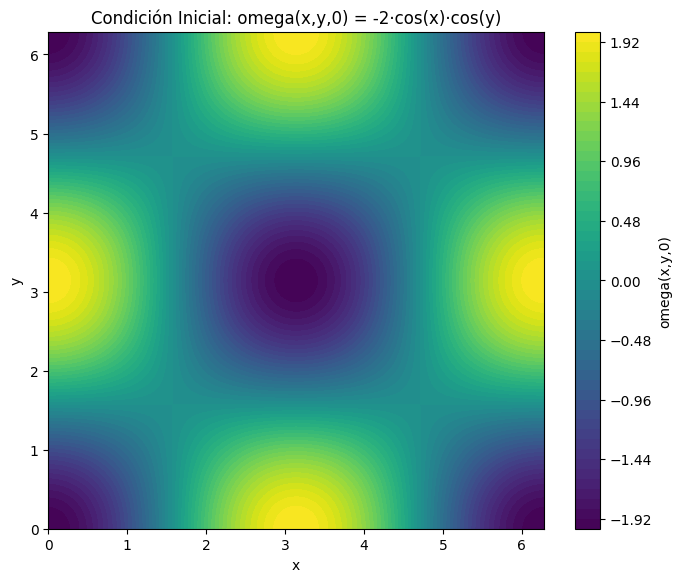

In [2]:
# Parámetros del dominio
Nx, Ny = 200, 200
DOMAIN = 2 * np.pi

# Malla espacial en [0,2π]×[0,2π]
x = np.linspace(0, DOMAIN, Nx)
y = np.linspace(0, DOMAIN, Ny)
X, Y = np.meshgrid(x, y)

# Condición inicial de vorticidad
omega0 = -2 * np.cos(X) * np.cos(Y)

# Representación gráfica
plt.figure(figsize=(8, 6.45))
cs = plt.contourf(X, Y, omega0, levels=50, cmap='viridis')
plt.colorbar(cs, label='omega(x,y,0)')
plt.title('Condición Inicial: omega(x,y,0) = -2·cos(x)·cos(y)')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')

plt.xlim(0, DOMAIN)
plt.ylim(0, DOMAIN)

plt.show()

In [3]:
# =============
# DEFINICION DEL MODELO

def computeGrads(y, x):
    grads, = torch.autograd.grad(y, x, grad_outputs=y.data.new(y.shape).fill_(1), create_graph=True)
    return grads

class Sine(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.sin(x)

# Parametros fisicos y de entrenamiento
nu = 0.1                           # viscosidad cinematica ν
DOMAIN = 2 * torch.pi              # dominio [0,2pi] en x,y
T_MAX = 1.0                        # tiempo maximo
N_STEPS = 2500                     # iteraciones de entrenamiento
N_COLLOC = 25000                   # puntos collocation para PDE
N_BC = 25000                       # puntos para condiciones de frontera e iniciales

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definicion de la MLP para approximar Psi(x,y,t)
class NAVIER(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, layers[0]),
            Sine(),
            *sum([[nn.Linear(layers[i], layers[i+1]), Sine()]
                  for i in range(len(layers)-1)], []),
            nn.Linear(layers[-1], 1)
        )
    def forward(self, x):
        return self.net(x)
    
# class NAVIER(nn.Module):
#     def __init__(self, layers):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(3, layers[0]),
#             nn.ReLU(),
#             *sum([[nn.Linear(layers[i], layers[i+1]), nn.ReLU()]
#                   for i in range(len(layers)-1)], []),
#             nn.Linear(layers[-1], 1)
#         )
#     def forward(self, x):
#         return self.net(x)
# 
# class NAVIER(nn.Module):
#     def __init__(self, layers):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(3, layers[0]),
#             nn.Tanh(),
#             *sum([[nn.Linear(layers[i], layers[i+1]), nn.Tanh()]
#                   for i in range(len(layers)-1)], []),
#             nn.Linear(layers[-1], 1)
#         )
#     def forward(self, x):
#         return self.net(x)

# Inicializar red, optimizador y scheduler
mlp = NAVIER([50,50,50,50,50,50]).to(device)
mse = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                milestones=[2500, 5000, 7500, 10000, 20000], gamma=0.25)

print(f"Modelo inicializado correctamente en {device}.")

Modelo inicializado correctamente en cuda.


In [4]:
# =============
# BUCLE DE ENTRENAMIENTO

# Parametros
EXTRA_EPOCHS = 10
lambda_ic    = 1000
lambda_bc    = 10
# lambda_ic    = 1
# lambda_bc    = 1
model_path   = 'models/stokes/lambdas/taylor_green'
os.makedirs(model_path, exist_ok=True)

# Carga de checkpoint previo
if os.path.exists(f"{model_path}.pth"):
    ckpt = torch.load(f"{model_path}.pth", map_location=device)
    mlp.load_state_dict(ckpt['model_state_dict'])
    optimizer.load_state_dict(ckpt['optimizer_state_dict'])
    scheduler.load_state_dict(ckpt['scheduler_state_dict'])
    start_epoch   = ckpt['epoch']
    print(f"Cargado checkpoint de la época {start_epoch-1:02d}.")
else:
    start_epoch   = 1
    print("No hay checkpoint previo. Empezando desde epoch 01.")

N_EPOCHS = start_epoch + EXTRA_EPOCHS

for epoch in range(start_epoch, N_EPOCHS):
    mlp.train()
    epoch_loss = 0.0

    # Bucle con tqdm
    loop = tqdm(range(1, N_STEPS+1),
                desc=f"Epoch {epoch:02d}",
                unit="step",
                delay=0.1,
                total=N_STEPS)

    for step in loop:
        # Puntos collocation (x,y,t) ∈ [0,2pi]^2 x [0,T_MAX]
        xy = torch.rand(N_COLLOC,2, device=device) * DOMAIN
        t  = torch.rand(N_COLLOC,1, device=device) * T_MAX
        X  = torch.cat([xy, t], dim=1).requires_grad_(True)

        # Prediccion de Psi y cálculo de u,v,omega
        psi = mlp(X).squeeze()
        grads = computeGrads(psi, X)
        psi_x, psi_y, psi_t = grads[:,0], grads[:,1], grads[:,2]
        u = -psi_y                    # u =  ∂Psi/∂y
        v =  psi_x                    # v = -∂Psi/∂x
        omega = computeGrads(v, X)[:,0] - computeGrads(u, X)[:,1]  # omega=∂x v - ∂y u

        # Residuo de la PDE de vorticidad: omega_t + u omega_x + v omega_y - ν Δomega = 0
        omega_t = computeGrads(omega, X)[:,2]
        omega_x = computeGrads(omega, X)[:,0]
        omega_y = computeGrads(omega, X)[:,1]
        lap_omega = computeGrads(omega_x, X)[:,0] + computeGrads(omega_y, X)[:,1]
        pde_res = omega_t + u*omega_x + v*omega_y - nu*lap_omega
        loss_pde = mse(pde_res, torch.zeros_like(pde_res))

        # Condicion inicial omega(x,y,0)=sin x sin y
        xy0 = torch.rand(N_BC,2, device=device) * DOMAIN
        t0  = torch.zeros(N_BC,1, device=device, requires_grad=True)
        X0  = torch.cat([xy0, t0], dim=1)
        psi0 = mlp(X0).squeeze()
        u0 = -computeGrads(psi0, X0)[:,1]
        v0 =  computeGrads(psi0, X0)[:,0]
        omega0_hat = computeGrads(v0, X0)[:,0] - computeGrads(u0, X0)[:,1]
        omega0 = -2 * torch.cos(xy0[:,0]) * torch.cos(xy0[:,1])
        loss_ic = lambda_ic*mse(omega0_hat, omega0)

        # Condiciones de frontera periodicas en x,y
        # emparejamos puntos en x=0 con x=2pi y analogo en y
        xb = torch.rand(N_BC,1,device=device)*DOMAIN
        yb = torch.rand(N_BC,1,device=device)*DOMAIN
        tb = torch.rand(N_BC,1,device=device)*T_MAX
        # frontera x=0 vs x=2pi
        Xb1 = torch.cat([torch.zeros_like(xb), yb, tb], dim=1).requires_grad_(True)
        Xb2 = torch.cat([DOMAIN*torch.ones_like(xb), yb, tb], dim=1).requires_grad_(True)
        # frontera y=0 vs y=2pi
        Xb3 = torch.cat([xb, torch.zeros_like(yb), tb], dim=1).requires_grad_(True)
        Xb4 = torch.cat([xb, DOMAIN*torch.ones_like(yb), tb], dim=1).requires_grad_(True)
        psi_b1 = mlp(Xb1).squeeze(); psi_b2 = mlp(Xb2).squeeze()
        psi_b3 = mlp(Xb3).squeeze(); psi_b4 = mlp(Xb4).squeeze()
        loss_bc = lambda_bc*(mse(psi_b1, psi_b2) + mse(psi_b3, psi_b4))

        # Paso de optimizacion
        loss = loss_pde + loss_ic + loss_bc

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()
        # Mostrar metricas en la barra
        loop.set_postfix({
            "pde": f"{loss_pde.item():.2e}",
            "ic":  f"{loss_ic.item():.2e}",
            "bc":  f"{loss_bc.item():.2e}"
        })

    # Promedio de loss de la epoch
    avg_epoch_loss = epoch_loss / N_STEPS
    print(f"Epoch {epoch:02d} concluida — avg loss: {avg_epoch_loss:.3e} — lr: {optimizer.param_groups[0]['lr']}")

    # Guardar checkpoint de la epoca
    checkpoint_path = f"{model_path}_{epoch:02d}.pth"
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': mlp.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss_pde': loss_pde,
        'loss_ic': loss_ic/lambda_ic,
        'loss_bc': loss_bc/lambda_bc
    }, checkpoint_path)

    # Guardar checkpoint general
    checkpoint_path = f"{model_path}.pth"
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': mlp.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }, checkpoint_path)

print("Entrenamiento completado.")

No hay checkpoint previo. Empezando desde epoch 01.


c:\Users\alfa\anaconda3\envs\TFGM\Lib\site-packages\torch\autograd\graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 01: 100%|██████████| 2500/2500 [14:10<00:00,  2.94step/s, pde=6.97e-03, ic=3.26e-02, bc=2.42e-03]


Epoch 01 concluida — avg loss: 1.023e+01 — lr: 0.00025


Epoch 02: 100%|██████████| 2500/2500 [14:13<00:00,  2.93step/s, pde=4.60e-03, ic=1.30e-02, bc=1.22e-03]


Epoch 02 concluida — avg loss: 2.942e-02 — lr: 6.25e-05


Epoch 03: 100%|██████████| 2500/2500 [14:34<00:00,  2.86step/s, pde=3.67e-03, ic=8.09e-03, bc=7.72e-04]


Epoch 03 concluida — avg loss: 1.568e-02 — lr: 1.5625e-05


Epoch 04: 100%|██████████| 2500/2500 [14:29<00:00,  2.87step/s, pde=3.09e-03, ic=5.91e-03, bc=5.90e-04]


Epoch 04 concluida — avg loss: 1.111e-02 — lr: 3.90625e-06


Epoch 05: 100%|██████████| 2500/2500 [1:20:34<00:00,  1.93s/step, pde=2.78e-03, ic=5.09e-03, bc=5.24e-04]     


Epoch 05 concluida — avg loss: 9.097e-03 — lr: 3.90625e-06


Epoch 06: 100%|██████████| 2500/2500 [8:19:05<00:00, 11.98s/step, pde=2.55e-03, ic=4.21e-03, bc=4.44e-04]       


Epoch 06 concluida — avg loss: 7.780e-03 — lr: 3.90625e-06


Epoch 07: 100%|██████████| 2500/2500 [14:37<00:00,  2.85step/s, pde=2.23e-03, ic=3.44e-03, bc=3.86e-04]


Epoch 07 concluida — avg loss: 6.603e-03 — lr: 3.90625e-06


Epoch 08: 100%|██████████| 2500/2500 [15:19<00:00,  2.72step/s, pde=2.00e-03, ic=2.95e-03, bc=3.33e-04]


Epoch 08 concluida — avg loss: 5.672e-03 — lr: 9.765625e-07


Epoch 09: 100%|██████████| 2500/2500 [15:16<00:00,  2.73step/s, pde=1.89e-03, ic=2.79e-03, bc=3.20e-04]


Epoch 09 concluida — avg loss: 5.174e-03 — lr: 9.765625e-07


Epoch 10: 100%|██████████| 2500/2500 [15:08<00:00,  2.75step/s, pde=1.82e-03, ic=2.68e-03, bc=3.05e-04]

Epoch 10 concluida — avg loss: 4.938e-03 — lr: 9.765625e-07
Entrenamiento completado.


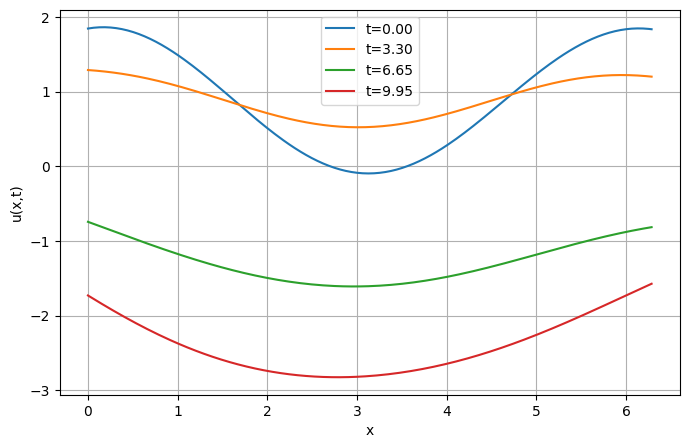

In [ ]:
# =============
# REPRESENTACION DE LA SOLUCION MLP

rc('animation', html='html5')

def run_mlp(Nx, dt, tf):
    """
    Simula la evolución usando la red MLP.
    """
    ps, ts = [], []
    t = 0.0
    x = np.linspace(0, 2*torch.pi, Nx)
    X0 = torch.from_numpy(x.reshape(-1, 1)).float()      # (Nx,1) para x
    Y0 = torch.zeros_like(X0)                            # (Nx,1) y=0
    mlp.eval(); mlp.cpu()

    while t <= tf:
        with torch.no_grad():
            T = torch.full((Nx, 1), t)                    # (Nx,1) para t
            X_t = torch.cat([X0, Y0, T], dim=1)           # (Nx,3)
            u_pred = mlp(X_t).squeeze()                   # (Nx,)
        ps.append(u_pred.numpy())
        ts.append(t)
        t += dt

    return ps, ts, x

# Parametros y simulacion
Nx, dt, tf = 200, 0.05, 10.0
ps, ts, x = run_mlp(Nx, dt, tf)

# Grafica estatica para varios instantes
plt.figure(figsize=(8,5))
for idx in [0, len(ts)//3, 2*len(ts)//3, -1]:
    plt.plot(x, ps[idx], label=f't={ts[idx]:.2f}')
plt.xlabel('x'); plt.ylabel('u(x,t)'); plt.legend(); plt.grid(True)
plt.show()

# Animacion de la evolucion completa
fig, ax = plt.subplots(figsize=(8,5))
line, = ax.plot([], [], lw=2)
ax.set_xlim(0,2*torch.pi)
ax.set_ylim(-4, 4)
ax.set_xlabel('x'); ax.set_ylabel('u(x,t)')

def init():
    line.set_data([], [])
    return (line,)

def update(i):
    line.set_data(x, ps[i])
    ax.set_title(f't = {ts[i]:.2f}')
    return (line,)

anim = animation.FuncAnimation(fig, update, init_func=init,
                               frames=len(ts), interval=100, blit=True)
plt.close(fig)
anim

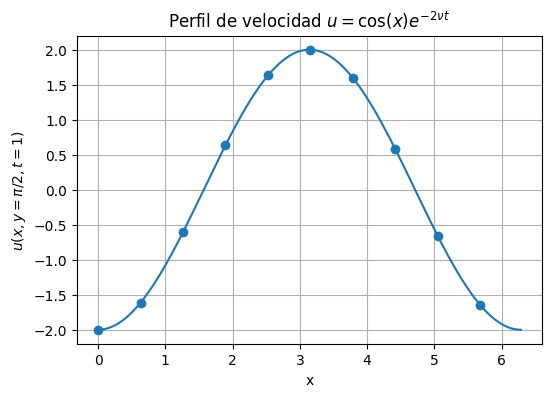

In [6]:
# =============
# REPRESENTACION DE LA SOLUCION EXACTA

# Parámetros
nu     = 0.01        # viscosidad cinemática
t0     = 0.0         # tiempo de snapshot
Nx     = 200
x      = np.linspace(0, 2*np.pi, Nx)

# Perfil analítico en y=π/2
u = -2 * np.cos(x) * np.exp(-2 * nu * t0)

# Gráfica
plt.figure(figsize=(6,4))
plt.plot(x, u, '-o', markevery=20)
plt.xlabel('x')
plt.ylabel(r'$u(x,y=\pi/2,t=1)$')
plt.title(r'Perfil de velocidad $u=\cos(x)e^{-2\nu t}$')
plt.grid(True)
plt.show()

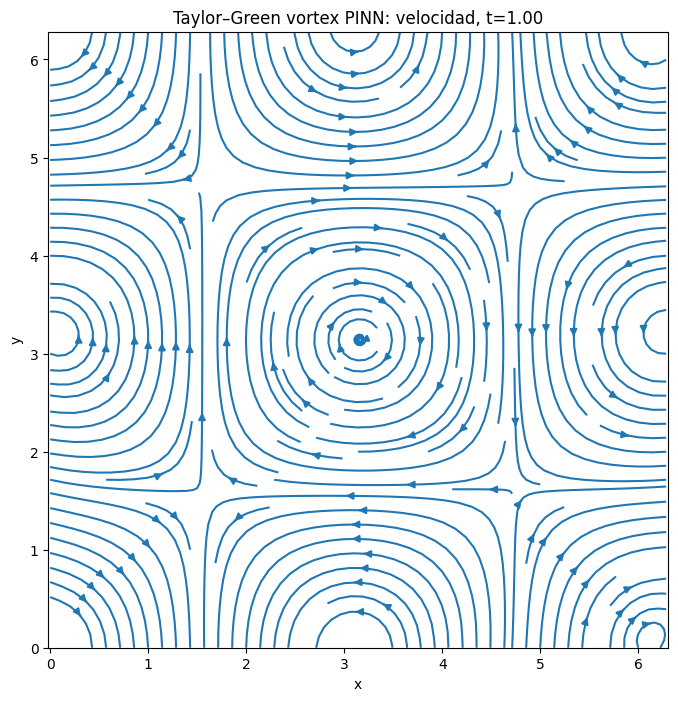

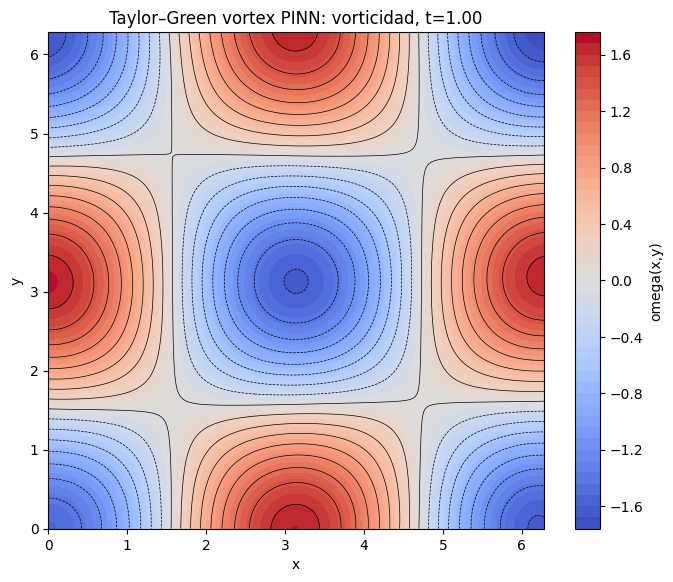

In [ ]:
# =============
# REPRESENTACION DEL PERFIL 2D MLP

def visualize_taylor_green(mlp, compute_grads, t_snapshot, Nx=200, Ny=200):
    mlp.eval()
    mlp.cpu()
    
    # Generación de la malla
    x = np.linspace(0, 2*np.pi, Nx)
    y = np.linspace(0, 2*np.pi, Ny)
    X, Y = np.meshgrid(x, y)
    XY = np.stack([X.ravel(), Y.ravel()], axis=1)
    T  = np.full((XY.shape[0],1), t_snapshot)
    inp = np.hstack([XY, T])
    inp_tensor = torch.from_numpy(inp).float()
    inp_tensor.requires_grad_(True)
    
    # Cálculo de psi y sus gradientes
    psi = mlp(inp_tensor).squeeze()
    grads = compute_grads(psi, inp_tensor)
    psi_x = grads[:, 0]  # ∂Ψ/∂x
    psi_y = grads[:, 1]  # ∂Ψ/∂y
    u = -psi_y
    v =  psi_x

    # Calculo de vorticidad omega = ∂v/∂x - ∂u/∂y
    u_grads = compute_grads(u, inp_tensor)
    v_grads = compute_grads(v, inp_tensor)
    du_dy = u_grads[:, 1]
    dv_dx = v_grads[:, 0]
    omega = dv_dx - du_dy

    # Reformateo para graficar
    u_plot = u.detach().numpy().reshape(Ny, Nx)
    v_plot = v.detach().numpy().reshape(Ny, Nx)
    omega_plot = omega.detach().numpy().reshape(Ny, Nx)
    
    # Figura 1: campo de velocidad (streamplot)
    plt.figure(figsize=(8,8))
    plt.streamplot(X, Y, u_plot, v_plot, density=1.5)  # dibujo de líneas de corriente
    plt.title(f'Taylor–Green vortex PINN: velocidad, t={t_snapshot:.2f}')
    plt.xlabel('x'); plt.ylabel('y'); plt.axis('equal')
    plt.show()

    # Grafica de contornos de vorticidad
    plt.figure(figsize=(8, 6.45))
    cs = plt.contourf(X, Y, omega_plot, levels=50, cmap='coolwarm')
    plt.colorbar(cs, label='omega(x,y)')
    plt.contour(X, Y, omega_plot, levels=20, colors='k', linewidths=0.5)
    plt.title(f'Taylor–Green vortex PINN: vorticidad, t={t_snapshot:.2f}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    plt.show()

visualize_taylor_green(mlp, computeGrads, t_snapshot = 1.0, Nx=200, Ny=200)

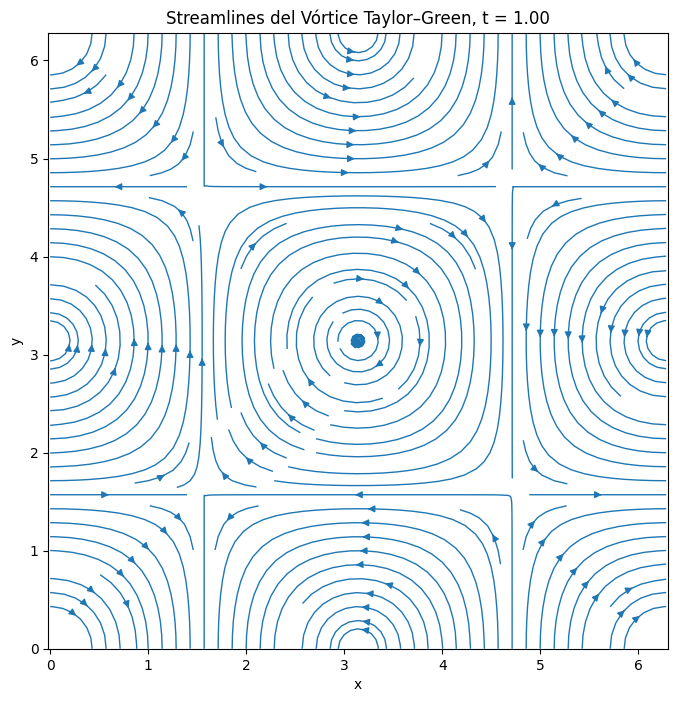

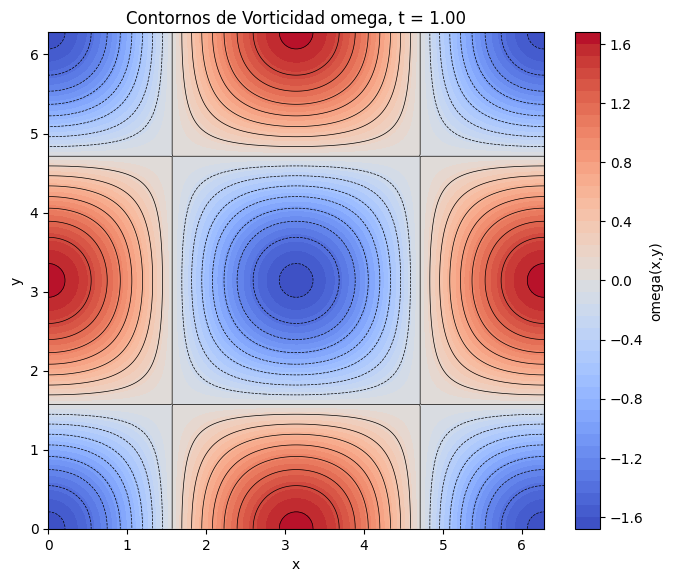

In [ ]:
# =============
# REPRESENTACION DEL PERFIL 2D REAL

# Parametros fisicos y de visualizacion
nu = 0.1               # viscosidad cinematica
t = 1.0                # instante de tiempo a visualizar
Nx, Ny = 200, 200       # resolucion de la malla en x,y

# Creamos la malla regular en [0,2pi]×[0,2pi]
x = np.linspace(0, 2*np.pi, Nx)
y = np.linspace(0, 2*np.pi, Ny)
X, Y = np.meshgrid(x, y)

# Evaluamos la solucion analitica u(x,y,t), v(x,y,t)
factor = np.exp(-2 * nu * t)
u =  np.cos(X) * np.sin(Y) * factor
v = -np.sin(X) * np.cos(Y) * factor

# Calculamos la vorticidad omega = ∂x v - ∂y u
omega = -2 * np.cos(X) * np.cos(Y) * factor

# Grafica de líneas de corriente (streamlines)
plt.figure(figsize=(8,8))
plt.streamplot(X, Y, u, v, density=1.5, linewidth=1, arrowsize=1)
plt.title(f'Streamlines del Vórtice Taylor–Green, t = {t:.2f}')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

# Grafica de contornos de vorticidad
plt.figure(figsize=(8, 6.45))
cs = plt.contourf(X, Y, omega, levels=50, cmap='coolwarm')
plt.colorbar(cs, label='omega(x,y)')
plt.contour(X, Y, omega, levels=20, colors='k', linewidths=0.5)
plt.title(f'Vorticidad del Vórtice Taylor–Green, t = {t:.2f}')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()